<a href="https://colab.research.google.com/github/kmcshane811/AutoML/blob/main/Generalised_Audio_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This page is generated from the corresponding jupyter notebook, that can be found on [this folder](https://github.com/fastaudio/fastaudio/tree/master/docs)

To install the library, uncomment and run this cell:

In [1]:
!pip install git+https://github.com/fastaudio/fastaudio.git
!pip install git+https://github.com/fastai/fastai/tree/v2.0-branch
!pip install -Uqq fastbook

import fastbook
fastbook.setup_book()
from fastbook import *

  Cloning https://github.com/fastaudio/fastaudio.git to /tmp/pip-req-build-ymkd_9th
  Running command git clone -q https://github.com/fastaudio/fastaudio.git /tmp/pip-req-build-ymkd_9th
  Created wheel for fastaudio: filename=fastaudio-0.1.4.post0.dev2+g8631a3f-py2.py3-none-any.whl size=18329 sha256=1b12afefb106b1e466f833dcdbcf8454e6b0bcb327cecaf2ad30dcae2d210b9b
  Stored in directory: /tmp/pip-ephem-wheel-cache-mxuscel0/wheels/20/af/b1/ea2a6d91971f5e3f435c6a0aa2ae8b7a010b644cc01e24b0ce
Successfully built fastaudio
  Cloning https://github.com/fastai/fastai/tree/v2.0-branch to /tmp/pip-req-build-mn49ukp1
  Running command git clone -q https://github.com/fastai/fastai/tree/v2.0-branch /tmp/pip-req-build-mn49ukp1
  fatal: repository 'https://github.com/fastai/fastai/tree/v2.0-branch/' not found
ERROR: Command errored out with exit status 128: git clone -q https://github.com/fastai/fastai/tree/v2.0-branch /tmp/pip-req-build-mn49ukp1 Check the logs for full command output.


**COLAB USERS: Before you continue and import the lib, go to the `Runtime` menu and select `Restart Runtime`.**

In [2]:
from fastai.vision.all import *
from fastai.vision.all import cnn_learner
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [ ]:
from google.colab import files
! pip install -q kaggle
print("Upload Kaggle Json")
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from kaggle import api 
! kaggle datasets download --force -d kinguistics/heartbeat-sounds


In [ ]:
! unzip heartbeat-sounds.zip

In [5]:
files.upload()

Saving set_a_adjusted.csv to set_a_adjusted.csv


{'set_a_adjusted.csv': b'dataset,fpath,label,sublabel,fname\r\na,set_a/artifact__201012172012.wav,artifact,,artifact__201012172012.wav\r\na,set_a/artifact__201105040918.wav,artifact,,artifact__201105040918.wav\r\na,set_a/artifact__201105041959.wav,artifact,,artifact__201105041959.wav\r\na,set_a/artifact__201105051017.wav,artifact,,artifact__201105051017.wav\r\na,set_a/artifact__201105060108.wav,artifact,,artifact__201105060108.wav\r\na,set_a/artifact__201105061143.wav,artifact,,artifact__201105061143.wav\r\na,set_a/artifact__201105190800.wav,artifact,,artifact__201105190800.wav\r\na,set_a/artifact__201105280851.wav,artifact,,artifact__201105280851.wav\r\na,set_a/artifact__201106010559.wav,artifact,,artifact__201106010559.wav\r\na,set_a/artifact__201106010602.wav,artifact,,artifact__201106010602.wav\r\na,set_a/artifact__201106021541.wav,artifact,,artifact__201106021541.wav\r\na,set_a/artifact__201106030612.wav,artifact,,artifact__201106030612.wav\r\na,set_a/artifact__201106031558.wav,ar

Opening the metadata file (For this particular model, the csv file must contain a filename and category (aka label) column.

In [4]:
path = Path()
meta = path.ls(file_exts=".csv")
print(meta)
csv_path = '/content/' + str(meta[-1])
df = pd.read_csv(csv_path)
print(path.ls())
file = str(input("Enter the filename that contains the dataset: "))
if file=="":
  file = "/content/"
else:
  file = "/content/"+file+"/"
print(file)
x = str(input("Enter column name containing filenames: "))
y = str(input("Enter column name containing labels: "))
df.head()



[Path('set_a_adjusted.csv')]
[Path('.config'), Path('heartbeat-sounds.zip'), Path('kaggle.json'), Path('gdrive'), Path('set_a'), Path('set_b'), Path('set_a_adjusted.csv'), Path('.ipynb_checkpoints'), Path('sample_data')]
Enter the filename that contains the dataset: set_a
/content/set_a/
Enter column name containing filenames: fname
Enter column name containing labels: label


,dataset,fpath,label,sublabel,fname
0,a,set_a/artifact__201012172012.wav,artifact,NaN,artifact__201012172012.wav
1,a,set_a/artifact__201105040918.wav,artifact,NaN,artifact__201105040918.wav
2,a,set_a/artifact__201105041959.wav,artifact,NaN,artifact__201105041959.wav
3,a,set_a/artifact__201105051017.wav,artifact,NaN,artifact__201105051017.wav
4,a,set_a/artifact__201105060108.wav,artifact,NaN,artifact__201105060108.wav


## Datablock and Dataloader preparation

Creating the Audio to Spectrogram transform from a predefined config & resize the samples to the same length.

In [5]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)
item_tfms = [ResizeSignal(4500),a2s]

/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  "At least one mel filterbank has all zero values. "


Creating the Datablock

In [6]:
auds = DataBlock(blocks = (AudioBlock, CategoryBlock), 
                 get_x = ColReader(x, pref=file), 
                 splitter = TrainTestSplitter(test_size=0.2, random_state=42, stratify=None, train_size=0.4, shuffle=True),
                 item_tfms = item_tfms,
                 get_y = ColReader(y))

In [7]:
dbunch = auds.dataloaders(df, bs=32)

/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Visualizing one batch of data. Notice that the title of each Spectrogram is the corresponding label.

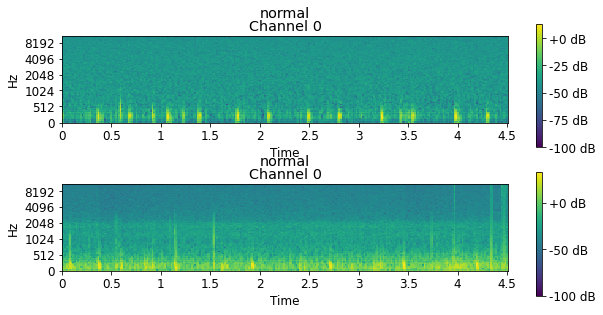

In [8]:
dbunch.show_batch(figsize=(10, 5))

## Learner and Training

While creating the learner, we need to indicate that our input spectrograms only have one channel. Besides that, it's the usual vision learner.

In [9]:
learn = cnn_learner(dbunch, 
            resnet18,
            n_in=1,  # <- This is the only audio specific modification here
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy])

In [10]:
@skip_if_ci
def run_learner():
    # epochs are a bit longer due to the chosen melspectrogram settings
    learn.fine_tune(10)

# We only validate the model when running in CI
run_learner()

epoch,train_loss,valid_loss,accuracy,time
0,2.313766,4.105415,0.280000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,2.203032,3.672826,0.160000,00:01
1,2.460765,3.291100,0.160000,00:01
2,2.335809,3.035272,0.240000,00:01
3,2.264315,2.729570,0.280000,00:01
4,2.046998,2.175542,0.320000,00:01
5,1.821058,2.255181,0.240000,00:01
6,1.664688,1.692495,0.320000,00:01
7,1.573168,1.524104,0.360000,00:01
8,1.441247,1.241830,0.520000,00:01
9,1.342770,1.182617,0.560000,00:01


RuntimeError: ignored

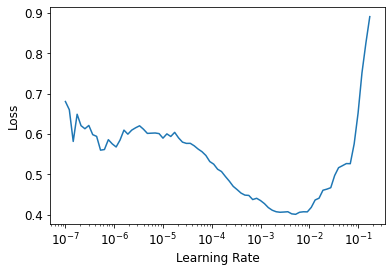

In [11]:
lr_min, lr_steep = learn.lr_find()

In [20]:
learn.fine_tune(6, base_lr = 10e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.257713,1.103581,0.760000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.156572,1.531069,0.600000,00:01
1,0.202063,1.751226,0.640000,00:01
2,0.173410,1.473816,0.640000,00:01
3,0.162957,1.606761,0.640000,00:01
4,0.130265,1.953680,0.680000,00:01
5,0.111279,1.316227,0.800000,00:01


In [ ]:
learn.export()